In [1]:
# CREDITS - https://idiotdeveloper.com/unet-segmentation-with-pretrained-mobilenetv2-as-encoder/

# Load the TensorBoard notebook extension
%reload_ext tensorboard

import os
import datetime
import matplotlib.pyplot as plt
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.python.keras.metrics import Recall, Precision
from tensorflow.python.keras.optimizer_v2.nadam import Nadam
from models.metrics.dice import dice_coefficient, dice_loss
import numpy as np

from utils.Dataset import MIRDCRicord1aDataset, array_to_rgb, read_image, read_mask

import models.UDenseNet169 as UDenseNet169
import models.UDenseNet201 as UDenseNet201
import models.UMobileNet as UMobileNet
import models.UMobileNetV2 as UMobileNetV2
import models.UResNet50 as UResNet50
import models.UResNet101 as UResNet101
import models.UVGG16Net as UVGG16Net
import models.UVGG19Net as UVGG19Net

In [2]:
import tensorflow as tf

if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [3]:
IMAGE_SIZE = 128
EPOCHS = 30
BATCH = 8
LR = 1e-4

dataset_path = os.path.abspath(os.path.join(os.pardir, 'data'))
dataset = MIRDCRicord1aDataset('\\\\?\\' + dataset_path)

In [4]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = dataset.load_data()

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  200
Validation data:  150
Testing data:  150


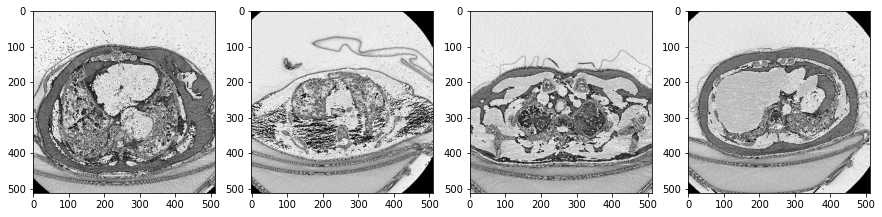

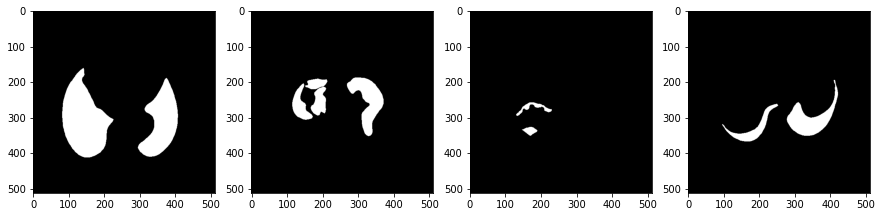

In [5]:
fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1, 4, 1)
plt.imshow(array_to_rgb(train_x[0]))
fig.add_subplot(1, 4, 2)
plt.imshow(array_to_rgb(train_x[1]))
fig.add_subplot(1, 4, 3)
plt.imshow(array_to_rgb(train_x[2]))
fig.add_subplot(1, 4, 4)
plt.imshow(array_to_rgb(train_x[3]))

fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1, 4, 1)
plt.imshow(array_to_rgb(train_y[0]))
fig.add_subplot(1, 4, 2)
plt.imshow(array_to_rgb(train_y[1]))
fig.add_subplot(1, 4, 3)
plt.imshow(array_to_rgb(train_y[2]))
fig.add_subplot(1, 4, 4)
plt.imshow(array_to_rgb(train_y[3]))

In [6]:
train_dataset = dataset.tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = dataset.tf_dataset(valid_x, valid_y, batch=BATCH)

In [7]:
opt = Nadam(LR)
metrics = [dice_coefficient, Recall(), Precision()]

models = {
    'udensene169': UDenseNet169.build_model((IMAGE_SIZE, IMAGE_SIZE, 3), metrics, dice_loss, opt),
    'udensenet201': UDenseNet201.build_model((IMAGE_SIZE, IMAGE_SIZE, 3), metrics, dice_loss, opt),
    'umobilenet': UMobileNet.build_model((IMAGE_SIZE, IMAGE_SIZE, 3), metrics, dice_loss, opt),
    'umobilenetv2': UMobileNetV2.build_model((IMAGE_SIZE, IMAGE_SIZE, 3), metrics, dice_loss, opt),
    'uresnet50': UResNet50.build_model((IMAGE_SIZE, IMAGE_SIZE, 3), metrics, dice_loss, opt),
    'uresnet101': UResNet101.build_model((IMAGE_SIZE, IMAGE_SIZE, 3), metrics, dice_loss, opt),
    'uvgg16net': UVGG16Net.build_model((IMAGE_SIZE, IMAGE_SIZE, 3), metrics, dice_loss, opt),
    'uvgg19nt': UVGG19Net.build_model((IMAGE_SIZE, IMAGE_SIZE, 3), metrics, dice_loss, opt)
}

In [8]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

histories = {}

def train_models():
    for key in models:
        print('Training model ', key)
        log_dir = os.path.join(os.getcwd(), "logs", key,"fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        checkpoint_path = os.path.join(os.getcwd(), "checkpoints", key, "model_checkpoint_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

        callbacks = [
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
            TensorBoard(log_dir=log_dir, histogram_freq=1),
            tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_best_only=True, save_weights_only=True, monitor='val_loss', verbose=1)
        ]

        histories[key] = models[key].fit(
            train_dataset,
            validation_data=valid_dataset,
            epochs=EPOCHS,
            steps_per_epoch=train_steps,
            validation_steps=valid_steps,
            callbacks=callbacks,
            verbose=1
        )
        print('\n')
    
try:
  # Do this if you have a GPU
  with tf.device(tf.test.gpu_device_name()):
      train_models()
except RuntimeError as e:
    train_models()

Training model  udensenet169
Epoch 1/30
25/25 [==============================] - 110s 3s/step - loss: 0.3810 - dice_coefficient: 0.0818 - recall: 0.8309 - precision: 0.0476 - val_loss: 0.1248 - val_dice_coefficient: 0.0855 - val_recall: 0.0957 - val_precision: 0.0470

KeyboardInterrupt: 

In [9]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

def predict_images(length_images, model):
    for i, (x, y) in enumerate(zip(test_x[:length_images], test_y[:length_images])):
        x = read_image(x, IMAGE_SIZE)
        y = read_mask(y, IMAGE_SIZE)
        y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
        h, w, _ = x.shape
        white_line = np.ones((h, 10, 3))

        all_images = [
            x, white_line,
            mask_parse(y), white_line,
            mask_parse(y_pred)
        ]
        image = np.concatenate(all_images, axis=1)

        fig = plt.figure(figsize=(12, 12))
        a = fig.add_subplot(1, 1, 1)
        img_plot = plt.imshow(image)

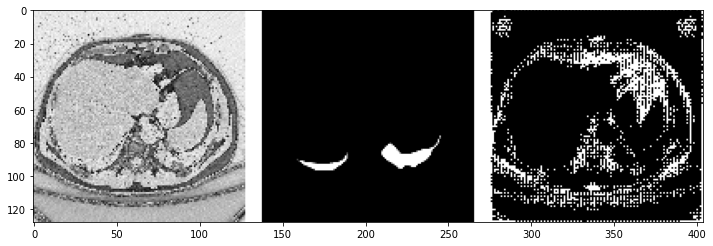

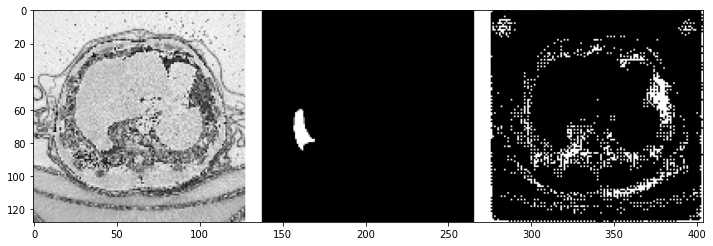

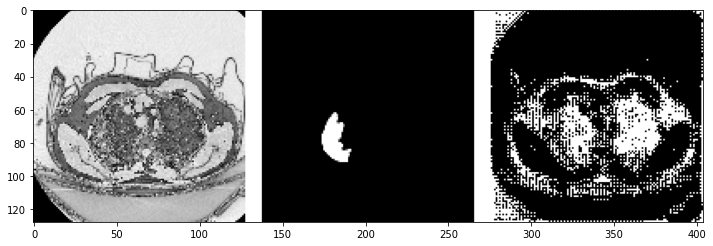

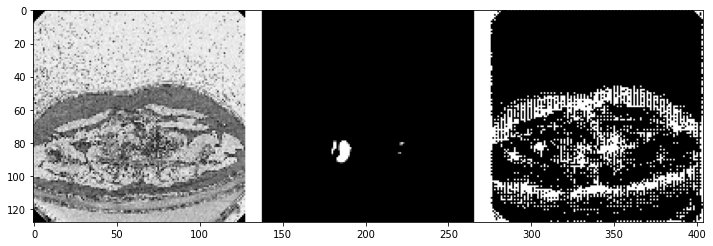

In [11]:
predict_images(4, models['uvgg16nt'])

In [12]:
test_steps = len(test_x)//BATCH

test_dataset = dataset.tf_dataset(test_x, test_y, batch=BATCH)


for key in models:
    # Evaluate the model on the test data using `evaluate`
    print("Evaluate on test data on network ", models[key].name)
    results = models[key].evaluate(
        test_dataset,
        steps=test_steps
    )
    print("dice_loss, dice_coef, recall, precision", results)
    print('\n')

Evaluate on test data on network  udensenet169
18/18 [==============================] - 5s 288ms/step - loss: 0.1241 - dice_coefficient: 0.0838 - recall: 0.4019 - precision: 0.0755